## Titanic: Machine Learning from Disaster
**Predict survival on the Titanic**
<hr>
I barely remember first when exactly I watched Titanic movie but still now Titanic remains a discussion subject in the most diverse areas. The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. It was April 15-1912 during her maiden voyage, the Titanic sank after colliding with an iceberg and killing 1502 out of 2224 passengers and crew. 

In this kaggle challenge, we're asked to complete the analysis of what sorts of people were likely to survive. In particular, we're asked to apply the tools of **machine learning** to predict which passengers survived the tragedy.

More challenge information and datasets are available on [Kaagle Titanic Page](https://www.kaggle.com/c/titanic/data) The datasets has been split into two groups:

- training set (train.csv)
- test set (test.csv)

## Look at the Big Picture <a class="anchor" id="4-bullet"></a>
<hr>

The goal is to build a Model that can predict the survival or the death of a given passenger based on a set of variables describing their such as age, sex, or passenger class on the boat.

### Frame the Problem

To frame the problem elegantly, is very much important because it will determine our problem spaces. What algorithms we will select, what performance measure we will use to evaluate our model and also how much effort we should spend tweaking it. 

The test set should be used to see how well our model performs on unseen data. For the test set, the ground truth for each passenger is not provided. It is our job to predict these outcomes. For each passenger in the test set, we use the trained model to predict whether or not they survived the sinking of the Titanic. We will use **Cross-validation** for evaluating estimator performance.

Basically, we've two datasets are available, a `train set` and a `test set`. We'll be using the training set to build our predictive model and the testing set will be used to validate that model. This is a binary classification problem. 

To solve this **ML** problem, topics like feature analysis, data visualization, missing data imputation, feature engineering, model fine tuning and various classification models will be addressed for ensemble modeling.

### Preprocessing

In Data Science or ML problem spaces, Data Preprocessing means a lot, which is to make the Data usable or clean before using it, like before fit the model.

Now, the real world data is so messy, like following -
* **inconsistant values**
* **duplicate records**
* **missing values**
* **invalid data**
* **outlier**

So what? Actually this is a matter of big concern. Because, Model can't handle missing data. So, we need to handle this manually. Actually there're many approaches we can take to handle missing value in our data sets, such as-

* **Remove observation/records that have missing values.** But..
  - data may randomly missing, so by doing this we may loss a lots of data
  - data may non-randomly missing, so by doing this we may also loss a lots of data, again we're also    introducing potential biases 
  
* **Imputation**
  - replace missing values with another values 
  - strategies: mean, median or highest frequency value of the given feature


## Table of Contents
<hr>
The steps we will go through:

[Get The Data](#2-bullet)

Here we explore what inside of the dataset and make our first commit on it.
    
[Feature Analysis To Gain Insights](#5-bullet)

First we try to find out outlier from our datasets. There're many method to dectect outlier but here we will use tukey method to detect it. Then we will do component analysis of our features.

[Feature Engineering](#9-bullet)

Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. And here, in our datasets there are few features that we can do engineering on it. I like to choose two of them.
    - Name
    - Family Size
    
[Predictive Modeling](#10-bullet)

Here, we will use various classificatiom models and compare the results. We'll use Cross-validation for evaluating estimator performance and fine-tune the model and observe the learning curve, of best estimator and finally, will do enseble modeling of with three best predictive model. 

[Submit Predictor](#11-bullet)

Create a CSV file and submit to Kaggle.

# Import <a class="anchor" id="1-bullet"></a>
<hr>
At first we will load some various libraries. At first sight it may be confusing but we will see the use cases each of them in details later on.

In [4]:
# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list
# ! kaggle competitions download -c titanic

In [5]:
# Data Processing and Visualization Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



#  Data Modelling Libraries
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, ExtraTreesClassifier,
                             VotingClassifier)

from sklearn.model_selection import (GridSearchCV, cross_val_score, cross_val_predict,
                                     StratifiedKFold, learning_curve)


from sklearn.metrics import (confusion_matrix, accuracy_score) 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
from collections import Counter

sns.set(style = 'white' , context = 'notebook', palette = 'deep')
warnings.filterwarnings('ignore', category = DeprecationWarning)
%matplotlib inline

# Get Data Sets<a class="anchor" id="2-bullet"></a>
<hr>
Using pandas, we now load the dataset. Basically two files, one is for training purpose and other is for testng.

In [6]:
# load the datasets using pandas's read_csv method
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# concat these two datasets, this will come handy while processing the data
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# separately store ID of test datasets, 
# this will be using at the end of the task to predict.
TestPassengerID = test['PassengerId']

## Look Inside <a class="anchor" id="3-bullet"></a>
Let's look what we've just loaded. Datasets size, shape, short description and few more.

In [7]:
# shape of the data set
train.shape

(891, 12)

So it has 891 samples with 12 features. That's somewhat big, let's top 5 sample of it.

In [8]:
# first 5 records
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Definitions of each features and quick thoughts:

- PassengerId. Unique identification of the passenger. It shouldn't be necessary for the machine learning model.

- Survived. Survival (0 = No, 1 = Yes). Binary variable that will be our target variable.
- Pclass. Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd). Ready to go.
- Name. Name of the passenger. We need to parse before using it.
- Sex. Gender Categorical variable that should be encoded. We can use dummy variable to encode it.
- Age. Age in years.
- SibSp. Siblings / Spouses aboard the Titanic.
- Parch. Parents / Children aboard the Titanic.
- Ticket. Ticket number. Big mess. 
- Fare. Passenger fare.
- Cabin. Cabin number.
- Embarked. Port of Embarkation , C = Cherbourg, Q = Queenstown, S = Southampton. Categorical feature that should be encoded. We can use feature mapping or make dummy vairables for it.

The main conclusion is that we already have a set of features that we can easily use in our machine learning model. But features like Name, Ticket, Cabin require an additional effort before we can integrate them.

In [9]:
# using info method we can get quick overview of the data sets
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


One things to notice, we have 891 samples or entries but columns like **Age**, **Cabin** and **Embarked** have some missing values. We can't ignore those. However, let's generate the descriptive statistics to get the basic quantitative information about the features of our data set.

In [10]:
# Descriptive Statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There are three aspects that usually catch my attention when I analyse descriptive statistics:

- **Min and max values**: This can give us an idea about the range of values and is helpful to detect outliers.

- **Mean and standard deviation**: The mean shows us the central tendency of the distribution, while the standard deviation quantifies its amount of variation.
- **Count**: Give us a first perception about the volume of missing data. 


Let's define a function for missing data analysis more in details.

In [11]:
# Create table for missing data analysis
def find_missing_data(data):
    Total = data.isnull().sum().sort_values(ascending = False)
    Percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    
    return pd.concat([Total,Percentage] , axis = 1 , keys = ['Total' , 'Percent'])

In [12]:
find_missing_data(train)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


Let's create a heatmap plot to visualize the amount of missing values.

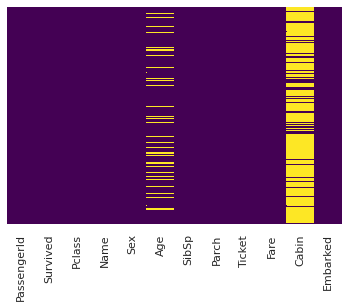

In [13]:
# checking only train set - visualize
sns.heatmap(train.isnull(), cbar = False , 
            yticklabels = False , cmap = 'viridis')

We can see that, Cabin feature has terrible amount of missing values, around 77% data are missing. Until now, we only see train datasets, now let's see amount of missing values in whole datasets.

In [14]:
find_missing_data(dataset)

,Total,Percent
Cabin,1014,0.774637
Survived,418,0.319328
Age,263,0.200917
Embarked,2,0.001528
Fare,1,0.000764
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000


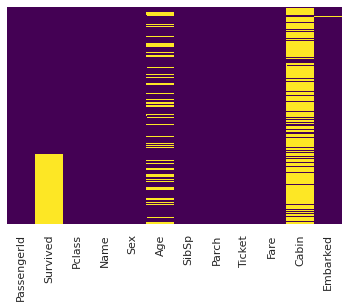

In [15]:
# checking only datasets set
sns.heatmap(dataset.isnull(), cbar = False , 
            yticklabels = False , cmap = 'viridis')

As it mentioned earlier, ground truth of test datasets are missing.

## Problem Spaces <a class="anchor" id="4-bullet"></a>

So, we've this train data set and with a quick analysis we've seen its internal components and find some missing values there. We've also seen many observations with concern attributes. 

**Task**: The goal is to predict the survival or the death of a given passenger based on a set of variables describing their such as age, sex, or passenger class on the boat.

So, **Survived** is our **target variable**, This is the variable we're going to predict. `1` represent **survived** , `0` represent **not survived**. And rest of the attributes are called **feature variables**, based on those we need to build a model which will predict whether a passenger survived or not.


### Preprocessing
In Data Science or ML contexts, Data Preprocessing means to make the Data usable or clean before using it, like before fit the model.

Now, the real world data is so messy, they're like -
* inconsistant
* duplicate records
* missing values
* invalid data
* outlier

# Feature Analysis <a class="anchor" id="5-bullet"></a>
<hr>

### Outlier Detection <a class="anchor" id="6-bullet"></a>

There are many method to detect outlier. We will use [Tukey Method](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/) to accomplish it.

In [16]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | 
                              (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
   
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)  

    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [17]:
# Show the outliers rows
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [18]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

# after removing outlier, let's re-concat the data sets
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

Now that we've removed outlier, let's analysis the various features and in the same time we'll also handle the missing value during analysis.

- Numerical Analysis
- Categorical Analysi

# Numerical Analysis  <a class="anchor" id="7-bullet"></a>
<hr>

At first let's analysis the correlation of 'Survived' features with the other numerical features like 'SibSp', 'Parch', 'Age', 'Fare'.

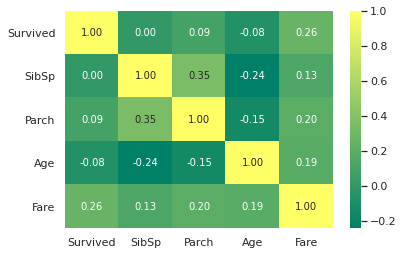

In [19]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
corr_numeric = sns.heatmap(dataset[["Survived","SibSp","Parch","Age","Fare"]].corr(),
                           annot=True, fmt = ".2f", cmap = "summer")

Only Fare feature seems to have a significative correlation with the survival probability.

But it doesn't make other features useless. Subpopulations in these features can be correlated with the survival. To estimate this, we need to explore in detail these features.

## Age

Let's first look the age distribution among survived and not survived passengers.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


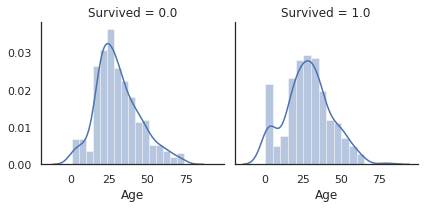

In [20]:
# Explore the Age vs Survived features
age_survived = sns.FacetGrid(dataset, col='Survived')
age_survived = age_survived.map(sns.distplot, "Age")

So, It's look like age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived. So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive. Let's look one for time.

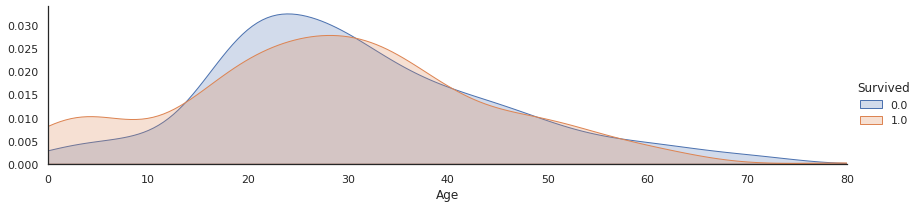

In [21]:
fig = sns.FacetGrid(dataset, hue = 'Survived', aspect = 4)
fig.map(sns.kdeplot, 'Age' , shade = True)
fig.set(xlim = (0, dataset['Age'].max()))
fig.add_legend()

Again we see that aged passengers between 65-80 have less survived.


## Missing Age Value

We have seen significantly missing values in **Age** coloumn. Missing Age value is a big issue, to address this problem, I've looked at the most correlated features with Age. Let's first try to find correlation between Age and Sex features.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


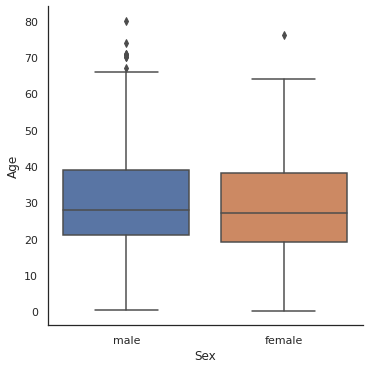

In [22]:
# visualize this using box plot
AS = sns.factorplot(y="Age", x="Sex", data = dataset, kind="box")

Age distribution seems to be almost same in Male and Female subpopulations, so Sex is not informative to predict Age. Let's explore `age` and `pclass` distribution.

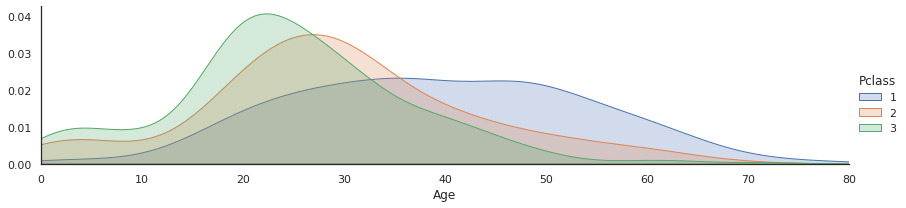

In [23]:
facet = sns.FacetGrid(dataset, hue="Pclass", aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.show()

So, we see there're more young people from class 3. First class passenger seems more aged than second class and third class are following. But we can't get any information to predict age. But let's try an another approach to visualize with the same parameter.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


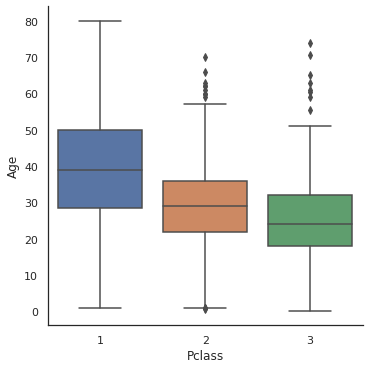

In [24]:
# using boxplot 
PA = sns.factorplot(data = dataset , x = 'Pclass' , y = 'Age', kind = 'box')

Here, we can get some information, First class passengers are older than 2nd class passengers who are also older than 3rd class passengers. We can easily visaulize that roughly `37, 29, 24` respectively are the median values of each classes. The strategy can be used to fill Age with the median age of similar rows according to Pclass.

In [25]:
# a custom function for age imputation
def AgeImpute(df):
    Age = df[0]
    Pclass = df[1]
    
    if pd.isnull(Age):
        if Pclass == 1: return 37
        elif Pclass == 2: return 29
        else: return 24
    else:
        return Age

# Age Impute
dataset['Age'] = dataset[['Age' , 'Pclass']].apply(AgeImpute, axis = 1)

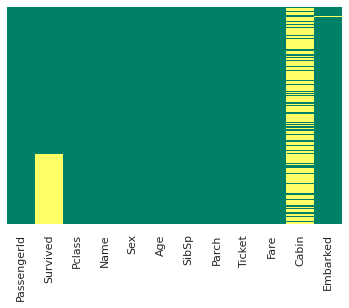

In [26]:
# age featured imputed; no missing age records
sns.heatmap(dataset.isnull(), yticklabels = False, cbar = False, cmap = 'summer')

`Fare` feature missing some values. However, we will handle it later.

## SibSP
Now, let's look `Survived` and `SibSp` features in details

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


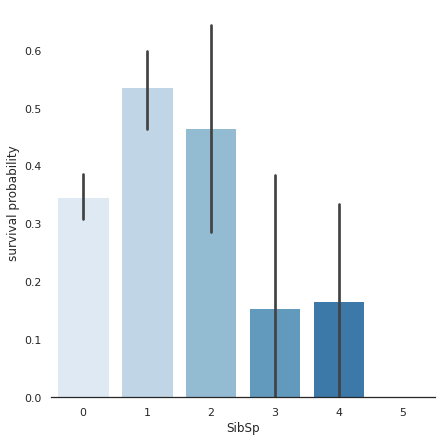

In [27]:
# Explore SibSp feature vs Survived
# We'll use factorplot to analysis
Sib_Sur = sns.factorplot(x="SibSp",y="Survived",data=train,
                   kind="bar", size = 6 , palette = "Blues")

Sib_Sur.despine(left=True)
Sib_Sur = Sib_Sur.set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive.
Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

## Parch
Let's look `Survived` and `Parch` features in details

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


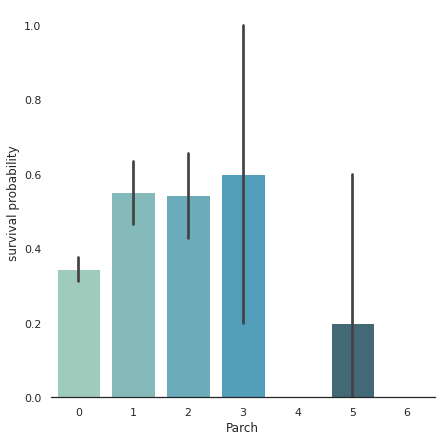

In [28]:
# Explore Parch feature vs Survived
# We'll use factorplot to analysis
Sur_Par = sns.factorplot(x="Parch",y="Survived",data=train, 
                         kind="bar", size = 6 , palette = "GnBu_d")

Sur_Par.despine(left=True)
Sur_Par = Sur_Par.set_ylabels("survival probability")

Small families have more chance to survive, more than single.

## Fare
Let's look `Survived` and `Fare` features in details. We have seen that, Fare feature also mssing some values. Let's handle it first.

In [29]:
dataset["Fare"].isnull().sum()

1

Since we have one missing value , I liket to fill it with the median value.

In [30]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

# Categorical values  <a class="anchor" id="8-bullet"></a>
<hr>

We can turn categorical values into numerical values. This is simply needed because of feeding the traing data to model. We can use feature mapping or create dummy variables.

## sex
Let's take a quick look of values in this features.

In [31]:
print(dataset['Sex'].head()) # top 5
print(' ')
print(dataset['Sex'].tail()) # last 5

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object
 
1294      male
1295    female
1296      male
1297      male
1298      male
Name: Sex, dtype: object


<hr>
Model can not take such values. We need to map the `sex` column to numeric values, so that our model can digest.

In [32]:
# convert Sex into categorical value 0 for male and 1 for female
sex = pd.get_dummies(dataset['Sex'], drop_first = True)
dataset = pd.concat([dataset,sex], axis = 1)

# After now, we really don't need to Sex features, we can drop it.
dataset.drop(['Sex'] , axis = 1 , inplace = True)

Let see how much people `survived` based on their `gender`. We can guess though, `Female` passenger survived more than `Male`, this is just assumption though. In the movie, we heard that **Women and Children First**.

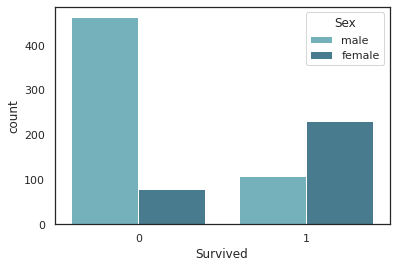

In [33]:
# using countplot to estimate amount
sns.countplot(data = train , x = 'Survived' , hue = 'Sex', palette = 'GnBu_d')

In [34]:
# let's see the percentage
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


It is clearly obvious that Male have less chance to survive than Female. This is heavily an important feature for our prediction task.

## Pclass
Let's explore passenger calsses feature with age feature. From this we can know, how much children, young and aged people were in different passenger class.

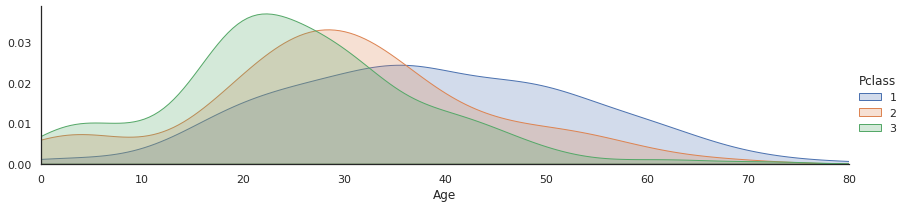

In [35]:
facet = sns.FacetGrid(train, hue="Pclass",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.show()

So, we see there're more young people from class 3. And more aged passenger were in first class, and that indicate that they're rich. So, most of the young people were in class three.

However, let's explore the `Pclass` vs `Survived` using `Sex` feature. This will give more information about the survival probability of each classes according to their gender.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


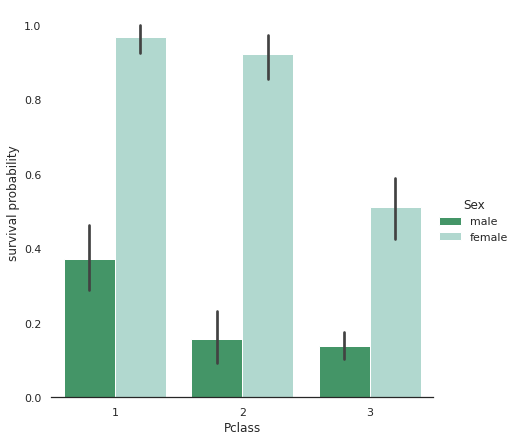

In [36]:
Survived_Pcalss = sns.factorplot(x="Pclass", y="Survived", 
                                 hue="Sex", data=train,size=6, 
                                 kind="bar", palette="BuGn_r")
Survived_Pcalss.despine(left=True)
Survived_Pcalss = Survived_Pcalss.set_ylabels("survival probability")

The passenger survival is not the same in the all classes. First class passengers have more chance to survive than second class and third class passengers. And Female survived more than Male in every classes.

## Embarked
<hr>
Port of Embarkation , C = Cherbourg, Q = Queenstown, S = Southampton. Categorical feature that should be encoded. We can use feature mapping or make dummy vairables for it.

However, let's explore it combining `Pclass` and `Survivied` features. So that, we can get idea about the classes of passengers and also the concern embarked.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


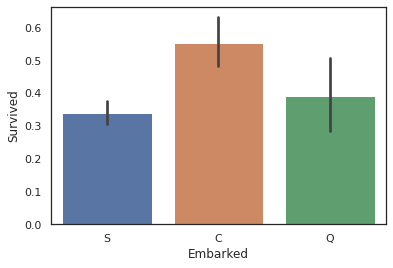

In [37]:
# 'Embarked' vs 'Survived'
sns.barplot(dataset['Embarked'], dataset['Survived']);

Looks like, coming from Cherbourg people have more chance to survive. But why? That's weird. Let's compare this feature with other variables.

In [38]:
# Count
print(dataset.groupby(['Embarked'])['PassengerId'].count())

# Compare with other variables
dataset.groupby(['Embarked']).mean()

Embarked
C    270
Q    123
S    904
Name: PassengerId, dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male
Embarked,,,,,,,,
C,690.655556,0.553571,1.851852,31.242296,0.400000,0.370370,62.336267,0.581481
Q,668.593496,0.389610,2.894309,25.963415,0.341463,0.113821,12.409012,0.512195
S,645.971239,0.339117,2.347345,28.973175,0.484513,0.409292,26.296450,0.683628


Oh, C passenger have paid more and travelling in a better class than people embarking on Q and S. Amount of passenger from S is larger than others. But survival probability of C have more than others. 

As we've seen earlier that Embarked feature also has some missing values, so we can fill them with the most fequent value of Embarked which is S (almost 904).

In [39]:
# count missing values
print(dataset["Embarked"].isnull().sum())

# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

2


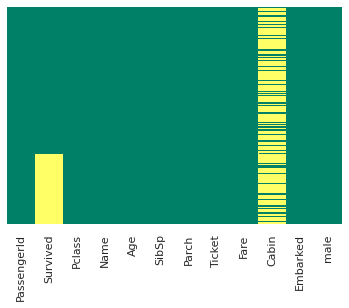

In [40]:
# let's visualize it to confirm
sns.heatmap(dataset.isnull(), yticklabels = False, 
            cbar = False, cmap = 'summer')

And there it goes. Now, there's no missing values in Embarked feature. Let's explore this feature a little bit more. We can viz the survival probability with the amount of classes passenger embarked on different port.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


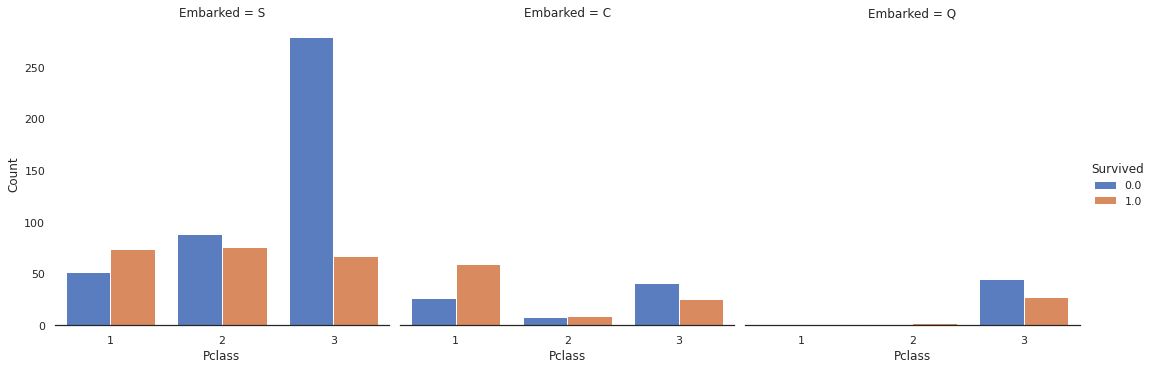

In [41]:
# Counting passenger based on Pclass and Embarked 
Embarked_Pc = sns.factorplot("Pclass", col="Embarked",  data=dataset,
                   size=5, kind="count", palette="muted", hue = 'Survived')

Embarked_Pc.despine(left=True)
Embarked_Pc = Embarked_Pc.set_ylabels("Count")

Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), and but Cherbourg passengers are mostly in first class. From this, we can also get idea about the economic condition of these region on that time.

However, We need to map the `Embarked` column to numeric values, so that our model can digest.

In [42]:
# create dummy variable
embarked = pd.get_dummies(dataset['Embarked'], drop_first = True)
dataset = pd.concat([dataset,embarked], axis = 1)

# after now, we don't need Embarked coloumn anymore, so we can drop it.
dataset.drop(['Embarked'] , axis = 1 , inplace = True)

# Commitment for Feature Analysis
So far, we've seen various subpopulation components of each features and fill the gap of missing values. We've done many visualization of each components and tried to find some insight of them. Though we can dive into more deeper but I like to end this here and try to focus on feature engineering. 

We saw that, we've many messy features like `Name`, `Ticket` and `Cabin`. We can do feature engineering to each of them and find out some meaningfull insight. But, I like to work on only `Name` variables. `Ticket` is, I think not too much important for prediction task and again almost 77% data missing in `Cabin` variables.

However, let's have a quick look over our datasets.

In [43]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,male,Q,S
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,1


# Feature Engineering <a class="anchor" id="9-bullet"></a>

[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is an informal topic, but it is considered essential in applied machine learning. Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

Some resources to get more depth on it -

- [Data Preprocessing and Feature Exploration](https://www.youtube.com/watch?v=V0u6bxQOUJ8&t=1384s)
- [Makes a Good Feature](https://www.youtube.com/watch?v=N9fDIAflCMY)
- [Feature Engineering](https://www.kdnuggets.com/tag/feature-engineering)
- [Automated Feature Engineering](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219)

Feature engineering is the art of converting raw data into useful features. There are several feature engineering techniques that you can apply. Some techniques are -

- Box-Cox transformations
- Polynomials generation through non-linear expansions

But we don't wanna be too serious on this rather than simply apply feature engineering approaches to get usefull information.

<hr>

## Name 

We can assume that people's title influences how they are treated. In our case, we have several titles (like Mr, Mrs, Miss, Master etc ), but only some of them are shared by a significant number of people. Accordingly, it would be interesting if we could group some of the titles and simplify our analysis.

Let's analyse the 'Name' and see if we can find a sensible way to group them. Then, we test our new groups and, if it works in an acceptable way, we keep it. For now, optimization will not be a goal. The focus is on getting something that can improve our current situation.


In [44]:
dataset['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [45]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]

# add dataset_title to the main dataset named 'Title'
dataset["Title"] = pd.Series(dataset_title)

# count
dataset["Title"].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
the Countess      1
Capt              1
Mme               1
Sir               1
Dona              1
Don               1
Jonkheer          1
Lady              1
Name: Title, dtype: int64

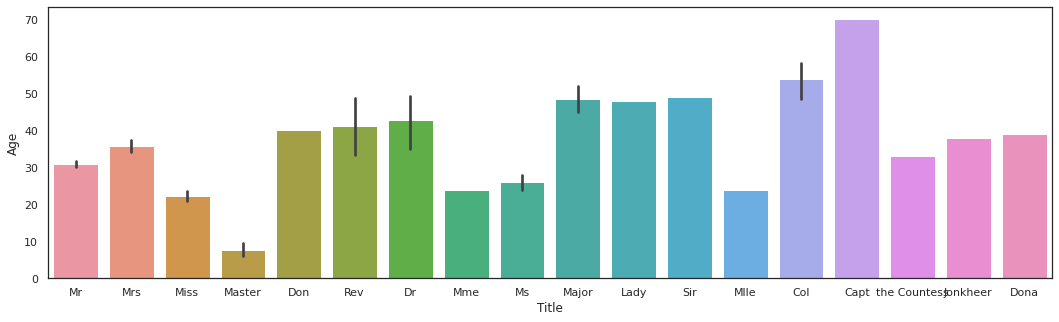

In [46]:
# Plot bar plot (titles and Age)
plt.figure(figsize=(18,5))
sns.barplot(x=dataset['Title'], y = dataset['Age'])

In [47]:
# Means per title
print(dataset.groupby('Title')['Age'].mean())

Title
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              42.750000
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           7.643000
Miss            22.261137
Mlle            24.000000
Mme             24.000000
Mr              30.926295
Mrs             35.898477
Ms              26.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64


There is 18 titles in the dataset and most of them are very uncommon so we like to group them in 4 categories.

In [48]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess',
                                             'Capt', 'Col','Don', 'Dr', 
                                             'Major', 'Rev', 'Sir', 'Jonkheer',
                                             'Dona'], 'Rare')

dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 ,
                                         "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, 
                                         "Rare":3})

dataset["Title"] = dataset["Title"].astype(int)

# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


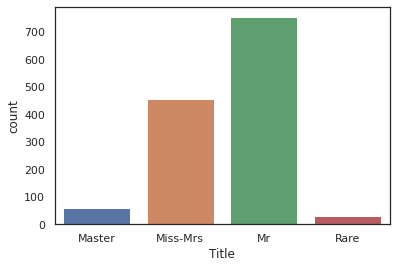

In [49]:
# viz counts the title coloumn
sns.countplot(dataset["Title"]).set_xticklabels(["Master","Miss-Mrs","Mr","Rare"]);

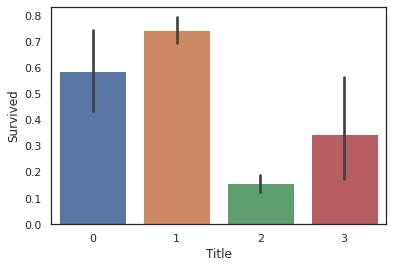

In [50]:
# Let's see, based on title what's the survival probability
sns.barplot(x='Title', y='Survived', data=dataset);

Catching Aspects:

- People with the title 'Mr' survived less than people with any other title.
- Titles with a survival rate higher than 70% are those that correspond to female (Miss-Mrs)

Our new category, 'Rare', should be more discretized. As we can see by the error bar (black line), there is a significant uncertainty around the mean value. Probably, one of the problems is that we are mixing male and female titles in the 'Rare' category. We should proceed with a more detailed analysis to sort this out. Also, the category 'Master' seems to have a similar problem. For now, we will not make any changes, but we will keep these two situations in our mind for future improvement of our data set.


From now on, there's no Name features and have Title feature to represent it.

In [51]:
# viz top 5
dataset.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,male,Q,S,Title
0,1,0.0,3,22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,2
1,2,1.0,1,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1
2,3,1.0,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,1
3,4,1.0,1,35.0,1,0,113803,53.1000,C123,0,0,1,1
4,5,0.0,3,35.0,0,0,373450,8.0500,NaN,1,0,1,2


##  Family size

I like to create a `Famize` feature which is the sum of `SibSp` , `Parch`.

In [52]:
# Create a family size descriptor from SibSp and Parch
dataset["Famize"] = dataset["SibSp"] + dataset["Parch"] + 1

# Drop SibSp and Parch variables
dataset.drop(labels = ["SibSp",'Parch'], axis = 1, inplace = True)

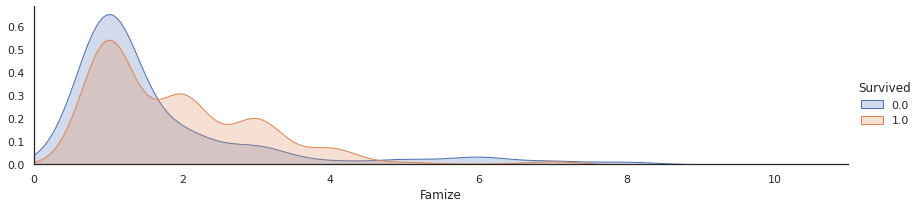

In [53]:
# Viz the survival probabily of Famize feature

facet = sns.FacetGrid(dataset, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Famize',shade= True)
facet.set(xlim=(0, dataset['Famize'].max()))
facet.add_legend()
plt.xlim(0);

Survival probability is worst for large families.

## Cabin & Ticket
Now, `Cabin` feature has a huge data missing. So, I like to drop it anyway. Moreover, we also can't get to much information by `Ticket` feature for prediction task.

In [54]:
# drop some useless features
dataset.drop(labels = ["Ticket",'Cabin','PassengerId'], axis = 1, 
             inplace = True)

# Predictive Modeling <a class="anchor" id="10-bullet"></a>
<hr>

Here, we split our datasets according to the previous amounts and make test and train set. To avoid overfitting event we can create validation set but that's not effective. So, we use [**K-Fold**](http://scikit-learn.org/stable/modules/cross_validation.html#k-fold) approaches and use [**StratifiedKFold**](http://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold) to split the train datasets into 10 (by default).

In [55]:
# Separate train dataset and test dataset
train = dataset[:len(train)]
test = dataset[len(train):]
test.drop(labels=["Survived"],axis = 1,inplace = True)

## Separate train features and label 
Y_train = train["Survived"].astype(int)
X_train = train.drop(labels = ["Survived"],axis = 1)

# Cross validate model with Kfold stratified cross val
K_fold = StratifiedKFold(n_splits=10)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Classifier <a class="anchor" id="11-bullet"></a>
<hr>

I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

- KNN
- AdaBoost
- Decision Tree
- Random Forest
- Extra Trees
- Support Vector Machine
- Gradient Boosting
- Logistic regression
- Linear Discriminant Analysis
- Multiple layer perceprton

## Evaluation using Cross Validation
A great alternative is to use Scikit-Learn's `cross-validation` feature. The following performs **K-fold** cross validation; it randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Models 10 times, picking a different fold for evaluation every time and training on the other 9 folds.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


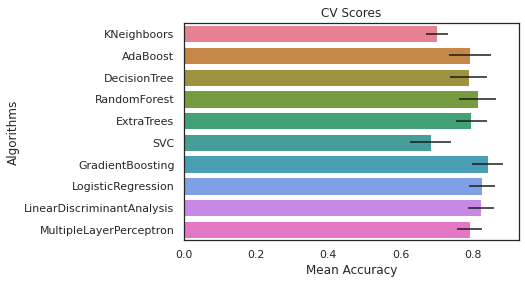

In [56]:
# Modeling step Test differents algorithms 
random_state = 2

models = [] # append all models or predictive models 
cv_results = [] # cross validation result
cv_means = [] # cross validation mean value
cv_std = [] # cross validation standard deviation

models.append(KNeighborsClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(RandomForestClassifier(random_state=random_state))
models.append(ExtraTreesClassifier(random_state=random_state))
models.append(SVC(random_state=random_state))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(LogisticRegression(random_state = random_state))
models.append(LinearDiscriminantAnalysis())
models.append(MLPClassifier(random_state=random_state))


for model in models :
    cv_results.append(cross_val_score(model, X_train, Y_train, 
                                      scoring = "accuracy", cv = K_fold, n_jobs=4))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_frame = pd.DataFrame(
    {
        "CrossValMeans":cv_means,
        "CrossValErrors": cv_std,
        "Algorithms":[
                     "KNeighboors",
                     "AdaBoost", 
                     "DecisionTree",   
                     "RandomForest",
                     "ExtraTrees",
                     "SVC",
                     "GradientBoosting",                      
                     "LogisticRegression",
                     "LinearDiscriminantAnalysis",
                     "MultipleLayerPerceptron"]
    })

cv_plot = sns.barplot("CrossValMeans","Algorithms", data = cv_frame,
                palette="husl", orient = "h", **{'xerr':cv_std})

cv_plot.set_xlabel("Mean Accuracy")
cv_plot = cv_plot.set_title("CV Scores")

Let's explore following models separately:

- GBC Classifier
- Linear Discriminant Analysis 
- Logistic Regression
- Random Forest Classifer
- Gaussian Naive Bayes
- Support Vectore Machine

In [57]:
# GBC Classifier
GBC_Model = GradientBoostingClassifier()

scores = cross_val_score(GBC_Model, X_train, Y_train, cv = K_fold,
                       n_jobs = 4, scoring = 'accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.83146067 0.82954545 0.76136364 0.89772727 0.90909091 0.875
 0.84090909 0.79545455 0.84090909 0.82954545]


84.11

In [58]:
# Linear Discriminant Analysis 
LDA_Model= LinearDiscriminantAnalysis()

scores = cross_val_score(LDA_Model, X_train, Y_train, cv = K_fold,
                       n_jobs = 4, scoring = 'accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.84269663 0.82954545 0.76136364 0.88636364 0.81818182 0.80681818
 0.79545455 0.78409091 0.86363636 0.84090909]


82.29

In [59]:
# Logistic Regression
#
Log_Model = LogisticRegression(C=1)
scores = cross_val_score(Log_Model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.80898876 0.85227273 0.77272727 0.88636364 0.82954545 0.79545455
 0.79545455 0.79545455 0.85227273 0.86363636]


82.52

In [60]:
# Random Forest Classifier Model
#
RFC_model = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(RFC_model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.76404494 0.85227273 0.77272727 0.80681818 0.89772727 0.80681818
 0.81818182 0.77272727 0.81818182 0.81818182]


81.28

In [61]:
# Gaussian Naive Bayes
GNB_Model = GaussianNB()

scores = cross_val_score(GNB_Model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.78651685 0.81818182 0.75       0.86363636 0.77272727 0.79545455
 0.80681818 0.78409091 0.85227273 0.84090909]


80.71

In [62]:
# Support Vector Machine
SVM_Model = SVC()

scores = cross_val_score(SVM_Model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.59550562 0.56818182 0.70454545 0.75       0.65909091 0.69318182
 0.70454545 0.73863636 0.71590909 0.70454545]


68.34

# Hyperparameter Tuning <a class="anchor" id="12-bullet"></a>
<hr>

I decided to choose this promising models of GradientBoosting, Linear Discriminant Analysis, RandomForest, Logistic Regression and SVM for the ensemble modeling. So, now we need to fine-tune them.

One way to do that would be to fiddle with the hyperparameters manually until we find a great combination of hyperparamerter values. This would be very tedious work, and we may not have time to explore many combination. Instead we should get `Scikit-Learn's GridSearchCV` to search for us. All we need to do is tell it which hyperparameters we want it to experiment with, and what values to try out and it will evaluate all the possible combination of hyperparameter values, using **cross-validation**.

Here we perform grid search optimization for GradientBoosting, RandomForest,  Linear Discriminant Analysis, Logistic Regression and SVC classifier.

In [ ]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {
              'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01, 0.001],
              'max_depth': [4, 8,16],
              'min_samples_leaf': [100,150,250],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=K_fold, 
                     scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   38.9s


In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "min_samples_split": [2, 6, 20],
              "min_samples_leaf": [1, 4, 16],
              "n_estimators" :[100,200,300,400],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=K_fold,
                     scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
# LogisticRegression Parameters tunning 
LRM = LogisticRegression()

## Search grid for optimal parameters
lr_param_grid = {"penalty" : ["l2"],
              "tol" : [0.0001,0.0002,0.0003],
              "max_iter": [100,200,300],
              "C" :[0.01, 0.1, 1, 10, 100],
              "intercept_scaling": [1, 2, 3, 4],
              "solver":['liblinear'],
              "verbose":[1]}


gsLRM = GridSearchCV(LRM, param_grid = lr_param_grid, cv=K_fold,
                     scoring="accuracy", n_jobs= 4, verbose = 1)

gsLRM.fit(X_train,Y_train)
LRM_best = gsLRM.best_estimator_

# Best score
gsLRM.best_score_

In [ ]:
# Linear Discriminant Analysis - Parameter Tuning
LDA = LinearDiscriminantAnalysis()

## Search grid for optimal parameters
lda_param_grid = {"solver" : ["svd"],
              "tol" : [0.0001,0.0002,0.0003]}


gsLDA = GridSearchCV(LDA, param_grid = lda_param_grid, cv=K_fold,
                     scoring="accuracy", n_jobs= 4, verbose = 1)

gsLDA.fit(X_train,Y_train)
LDA_best = gsLDA.best_estimator_

# Best score
gsLDA.best_score_

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100, 200, 300]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = K_fold,
                      scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

##  Plot Learning Curves <a class="anchor" id="13-bullet"></a>
**Diagnose Bias and Variance to Reduce Error**
<hr>
Learning curves are a good way to see the overfitting and underfitting effect on the training set and the effect of the training size on the accuracy. Learning curves plots the model's performance on the training set and the validation set as a function of training set size. To generate the plots, we simply train the model several times on different sized subsets of the training sets. In a nutshell, a learning curves shows how error changes as the training set size increases.

If a models perform well on the training data but generalizes poorly according to the cross-validation metrics, the model is called overfitting. And again if it performs poorly on both, the model is called underfitting.

When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error will be initially quite big.

> **Underfitting**: If model is underfitting the training data, adding more training example will not help. We need to use more complex model or come up with better features.

> **Overfitting**: One way to improve the overfitting model is to feed it more training data until the validation error reaches the training error.

**Resource**
- [Learning Curves for Machine Learning](https://www.dataquest.io/blog/learning-curves-machine-learning/)


## Bias-Variance Trade-Off
<hr>
A model's generalization error can be expressed as the sum of three very different errors.

- Bias
- Variance
- Irreducible Error

#### Bias Error in Learning Curve
This part of generalization error is due to the wrong assumption, such as assuming that, the data is linear when it is actually quadratic.

- **A high bias model is most likely to underfit the training data**


#### Variance Error in Learning Curve
This part of generalization is due to the model is excessive sensitivity to small variations in the training data.

- **A high variance model is most likely to overfit the training data**

#### Irreducible Error in Learning Curve
This is due to the noisiness of the data itself. This is not concern now, because we already clean the data sets.

<hr>

Increasing a model's complexity will typically increases its variance and reduce its bias. Conversly, reducing a model's complexity increases its bias and reduces its variance.


Now, we'll define a learning curve ploting function where `x` and `y` axies will be traning set size and scores (not errors) gradually. So the higher the score, the better the performance of the model.

In [ ]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
# Gradient boosting - Learning Curve 
plot_learning_curve(estimator = gsGBC.best_estimator_,title = "GBC learning curve",
                    X = X_train, y = Y_train, cv = K_fold);

In [ ]:
# Random Forest - Learning Curve
plot_learning_curve(estimator = gsRFC.best_estimator_ ,title = "RF learninc curve",
                    X = X_train, y = Y_train, cv = K_fold);

In [ ]:
# Logistic Regression - Learning Curve    gsLRM.best_estimator_
plot_learning_curve(estimator = Log_Model ,title = "Logistic Regression - Learning Curve",
                    X = X_train, y = Y_train, cv = K_fold);

In [ ]:
# Linear Discriminant Analysis - Learning Curve
plot_learning_curve(estimator = gsLDA.best_estimator_ ,title = "Linear Discriminant - Learning Curve",
                    X = X_train, y = Y_train, cv = K_fold);

In [ ]:
# Support Vector Machine - Learning Curve
plot_learning_curve(estimator = gsSVMC.best_estimator_,title = "SVC learning curve",
                    X = X_train, y = Y_train, cv = K_fold);

SVC seem to better generalize the prediction since the training and cross-validation curves are close together. And again Random Forest and GradientBoosting classifiers tend to overfit the training set. One way to improve the overfitting model is to feed it more training data until the validation error reaches the training error.

# Ensemble modeling <a class="anchor" id="14-bullet"></a>
<hr>

The another way to fine-tune our system is to try to combine the models that perform best. The goup will often perform better than the best individual model, especially if the individual models make very different types of errors.

Building a model on top of many other models are called Ensemble Learning. And it is often a great way to push ML algorithm even further.

I used **voting classifier** to combine the predictions coming from the 5 classifiers. I preferred to pass the argument `soft` to the voting parameter to take into account the probability of each vote.

In [ ]:
#about 84%
VotingPredictor = VotingClassifier(estimators =
                           [('rfc', RFC_best), 
                            ('gbc', GBC_best)],
                           voting='soft', n_jobs = 4)

# 82.97%
# VotingPredictor = VotingClassifier(estimators =
#                            [ ('rfc', RFC_best), 
#                             ('svc', SVMC_best),
#                             ('gbc', GBC_best),
#                             ('lda', LDA_best),
#                             ('lrm', LRM_best)],
#                            voting='soft', n_jobs = 4)

VotingPredictor = VotingPredictor.fit(X_train, Y_train)

scores = cross_val_score(VotingPredictor, X_train, Y_train, cv = K_fold,
                       n_jobs = 4, scoring = 'accuracy')

print(scores)
print(round(np.mean(scores)*100, 2))

In [ ]:
# Voting Predictor - Learning Curve
plot_learning_curve(estimator = VotingPredictor, title = "VP learning curve",
                    X = X_train, y = Y_train, cv = K_fold);

## Submit Predictor  <a class="anchor" id="15-bullet"></a>
**Kaggle : Titanic Competition**

In [ ]:
Predictive_Model = pd.DataFrame({
        "PassengerId": TestPassengerID,
        "Survived": VotingPredictor.predict(test)})

Predictive_Model.to_csv('titanic_model.csv', index=False)

In [ ]:
# Let's look inside
submission = pd.read_csv('titanic_model.csv')
submission.head()